Logistic Regression Baseline Tests
====

## 1. Importing Dependencies


In [83]:
# Import modules
import sys
from csv import reader
from typing import List
from nltk.tokenize import RegexpTokenizer
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import BinaryCrossentropy as bc
from keras.regularizers import l2
import keras.backend as K
from nltk.stem import LancasterStemmer
import inflect
import matplotlib.pyplot as plt


## 2. Initial Setup - Defining the driving variables, select dataset

In [84]:
# Determines which dataset use and how much to use :
# HateSpeech: Column-0 : Sentence, Column-1 : Label [noHate-0, Hate-1]
# either 'HateSpeech' or 'KaggleTwitter' or 'TDavidson'
dataset_to_use = "TDavidson"
dataset_percentage = 100  # percentage range 1 to 100

# Initializes file path, column of csv file to parse and
# the delimiter for parsing
training_file = ""
test_file = ""
sentence_column_to_parse = None
label_column_to_parse = None
lancaster = LancasterStemmer()
delimiter = ","
if dataset_to_use == "HateSpeech":
    training_file = "datasets/hate-speech/train.txt"
    test_file = "datasets/hate-speech/test.txt"
    delimiter = "\t"
    sentence_column_to_parse = 0
    label_column_to_parse = 1
elif dataset_to_use == "KaggleTwitter":
    training_file = "datasets/kaggle-twitter/newtrain.csv"
    test_file = "datasets/kaggle-twitter/newtest.csv"
    sentence_column_to_parse = 0
    label_column_to_parse = 1
elif dataset_to_use == "TDavidson":
    training_file = "datasets/t-davidson-hate-speech/train.csv"
    test_file = "datasets/t-davidson-hate-speech/test.csv"
    sentence_column_to_parse = 0
    label_column_to_parse = 1
else:
    print("Invalid Dataset specified")
    sys.exit(1)

## 3. Parsing the Data

In [85]:
def parse_data(training_file_path: str, percentage: int,
               sentence_column: int, label_column: int,
               delimit: str) -> List[str]:
    """This function is used to parse input lines
    and returns a the provided percent of data.

    Args:
        lines (List[str]): list of lines
        percentage (int): percent of the dataset needed
        sentence_column (int): sentence column from the dataset
        label_column (int): label column from the dataset
        delimit (str): delimiter
    Returns:
        List[str], List[str]: examples , labels -> [percentage of dataset]
    """
    percentage_sentences = []
    percentage_labels = []
    with open(training_file_path, "r", encoding="utf8",
              errors="ignore") as csvfile:
        read_sentences = []
        label_sentences = []
        csv_reader = reader(csvfile, delimiter=delimit)
        # skipping header
        header = next(csv_reader)
        # line_length = len(list(csv_reader_copy))
        if header is not None:
            for row in csv_reader:
                read_sentences.append(row[sentence_column])
                label_sentences.append(row[label_column])
        end_of_data = int(len(read_sentences) * percentage * .01)

        zipped = np.array(list(zip(read_sentences,label_sentences)))
        idx = [i for i in range(zipped.shape[0])]

        rng = np.random.default_rng(15)
        rand_idx = rng.choice(idx, size=end_of_data, replace=False)
        percentage_zipped = np.array([zipped[j] for j in rand_idx])

        percentage_sentences = percentage_zipped[:,0]
        percentage_labels = percentage_zipped[:,1]
    return percentage_sentences, percentage_labels

In [86]:
train_sentences, train_labels = parse_data(training_file,
                                           dataset_percentage,
                                           sentence_column_to_parse,
                                           label_column_to_parse,
                                           delimiter)

test_sentences, baseline_gold_labels = parse_data(
    test_file, dataset_percentage,
    sentence_column_to_parse,
    label_column_to_parse, delimiter)

## 4. Preprocessing the Data

### Seven tasks are done as part of this:
  - lower word case
  - remove stopwords
  - remove punctuation
  - convert numbers to texts
  - perform stemming
  - tokenize
  - Add - \<s> and \</s> for every sentence

In [87]:
def replace_numbers(sentence:List[str]) -> List[str]:
    """Replace all interger occurrences in list of tokenized words
    with textual representation"""
    p = inflect.engine()
    new_words = []  
    for word in sentence.split():
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return " ".join(new_words)

def stem_words(sentence: List[str]) -> List[str]:
    """Stems the given sentence

    Args:
        sentence (list): words to be stemmed

    Returns:
        str: stemmed sentence
    """
    stemmed_words = []
    for word in sentence.split():
        stemmed_words.append(lancaster.stem(word))
    return " ".join(stemmed_words)

def preprocessing(running_lines: List[str]) -> List[List[str]]:
    """This function takes in the running test and return back the
    preprocessed text. Seven tasks are done as part of this:
      1. lower word case
      2. remove stopwords
      3. remove punctuation
      4. convert numbers to texts
      5. perform stemming
      6. tokenize
      7. Add - <s> and </s> for every sentence

    Args:
        running_lines (List[str]): list of lines

    Returns:
        List[List[str]]: list of tokenized sentences which are processed
    """
    preprocessed_lines = []
    tokenizer = RegexpTokenizer(r"\w+")
    for line in running_lines:
        lower_case_data = line.lower()
        data_without_stop_word = remove_stopwords(lower_case_data)
        data_without_punct = strip_punctuation(data_without_stop_word)
        processed_data = replace_numbers(data_without_punct)
        processed_data = stem_words(processed_data)
        processed_data = tokenizer.tokenize(data_without_punct)
        processed_data.insert(0, "<s>")
        processed_data.append("</s>")
        preprocessed_lines.append(" ".join(processed_data))
    return preprocessed_lines

In [88]:
# parse and preprocess the data
processed_train_sentences = preprocessing(train_sentences)

processed_test_sentences = preprocessing(test_sentences)

## 5. Featurize the data

Features:
- \# positive words (from lexicon)
- \# negative words (from lexicon)
- If ! exists
- Bias

In [89]:
positive_words_lexicon = open(
            "positive_words.txt").read().split()
negative_words_lexicon = open(
            "negative_words.txt").read().split()

def featurize(data: str)-> List[str]:
        """
        we use this format to make implementation of this class
        more straightforward and to be
        consistent with what you see in nltk
        Parameters:
          data - str like "I loved the hotel"
        Return: a list of tuples linking features to values
        for BoW, a list of tuples linking every word to True [("I", True), ("loved", True), ("it", True)]
        """
        # We are considering four features + one bias for this
        # 1. Count (+ve lexicon  in document/sentence)
        # 2. Count (-ve lexicon in document/sentence)
        # 3. If '!' exists in document then 1, else 0
        # 4. Log(wordcount)
        # 5. Bias
        # Note: to get the best f1 score in the test set, I am considering
        # the first three features plus bias. However, to run all four features
        # uncomment the line 272, 338, and 346; comment line:271 and 345
        words = data.split()
        x1 = 0
        x2 = 0
        x3 = 1 if '!' in data else 0
        # x4 = np.log(len(words))
        x5 = 1
        for word in words:
            if word in positive_words_lexicon:
                x1 += 1
            if word in negative_words_lexicon:
                x2 += 1
        feature_list = [x1, x2, x3, x5]
        # feature_list = [x1, x2, x3, x4, x5]
        return feature_list

Also calculate class weights, and convert labels to integers

In [90]:
featurized_train = [featurize(s) for s in processed_train_sentences]
featurized_test = [featurize(s) for s in processed_test_sentences]

train_labels = [int(x) for x in train_labels]

baseline_gold_labels = [int(x) for x in baseline_gold_labels]

poscount = sum(train_labels)
negcount = len(train_labels) - poscount
posweight = 1./poscount
negweight = 1./negcount

classwt = {0: negweight, 1:posweight}

## 6. Building Model

### 6.1 Define Metric Functions

In [91]:
def get_f1(y_true: List[int], y_pred: List[int]) -> float:
    """generates the f1 score

    Args:
        y_true (List[int]): y gold labels
        y_pred (List[int]): y pred labels

    Returns:
        float: computed f1 score
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def get_precision(y_true: List[int], y_pred: List[int]) -> float:
    """generates the precision

    Args:
        y_true (List[int]): y gold labels
        y_pred (List[int]): y pred labels

    Returns:
        float: computed precision
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def get_recall(y_true: List[int], y_pred: List[int]) -> float:
    """generates the recall

    Args:
        y_true (List[int]): y gold labels
        y_pred (List[int]): y predicted labels

    Returns:
        float: computed recall
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

### 6.2 Create Baseline Model - Logistic Regression to Perform Binary Clasification

This is done using a Keras sequential model, with 1 single node using sigmoid activation. This was done to make used of the l2 regularizer, since the data is not evenly split between the classes

In [92]:
model = Sequential()
model.add(Dense(1, input_dim=4, activation='sigmoid', kernel_regularizer=l2()))
model.compile(optimizer="adam", loss=bc(), metrics=['accuracy', get_f1, get_precision, get_recall])

### 6.3 Train the model

In [93]:
data_history = model.fit(featurized_train,train_labels,
                epochs=20,
                class_weight=classwt)

Epoch 1/20
123/123 [==============================] - 1s 1ms/step - loss: 0.0217 - accuracy: 0.3992 - get_f1: 0.4189 - get_precision: 0.2821 - get_recall: 0.8763
Epoch 2/20
123/123 [==============================] - 0s 1ms/step - loss: 0.0159 - accuracy: 0.4013 - get_f1: 0.4197 - get_precision: 0.2825 - get_recall: 0.8731
Epoch 3/20
123/123 [==============================] - 0s 1ms/step - loss: 0.0115 - accuracy: 0.4056 - get_f1: 0.4164 - get_precision: 0.2813 - get_recall: 0.8527
Epoch 4/20
123/123 [==============================] - 0s 1ms/step - loss: 0.0082 - accuracy: 0.4521 - get_f1: 0.4141 - get_precision: 0.2894 - get_recall: 0.7784
Epoch 5/20
123/123 [==============================] - 0s 1ms/step - loss: 0.0057 - accuracy: 0.5456 - get_f1: 0.4160 - get_precision: 0.3266 - get_recall: 0.6535
Epoch 6/20
123/123 [==============================] - 0s 1ms/step - loss: 0.0040 - accuracy: 0.6337 - get_f1: 0.4126 - get_precision: 0.3547 - get_recall: 0.5265
Epoch 7/20
123/123 [========

In [94]:
eh = model.evaluate(x=featurized_test,
                    y=baseline_gold_labels)

eval_history = {"loss": eh[0], "accuracy": eh[1], "get_f1": eh[2], "get_precission": eh[3],
 "get_recall": eh[4]}

53/53 [==============================] - 0s 806us/step - loss: 0.6892 - accuracy: 0.7467 - get_f1: 0.0143 - get_precision: 0.0566 - get_recall: 0.0082       


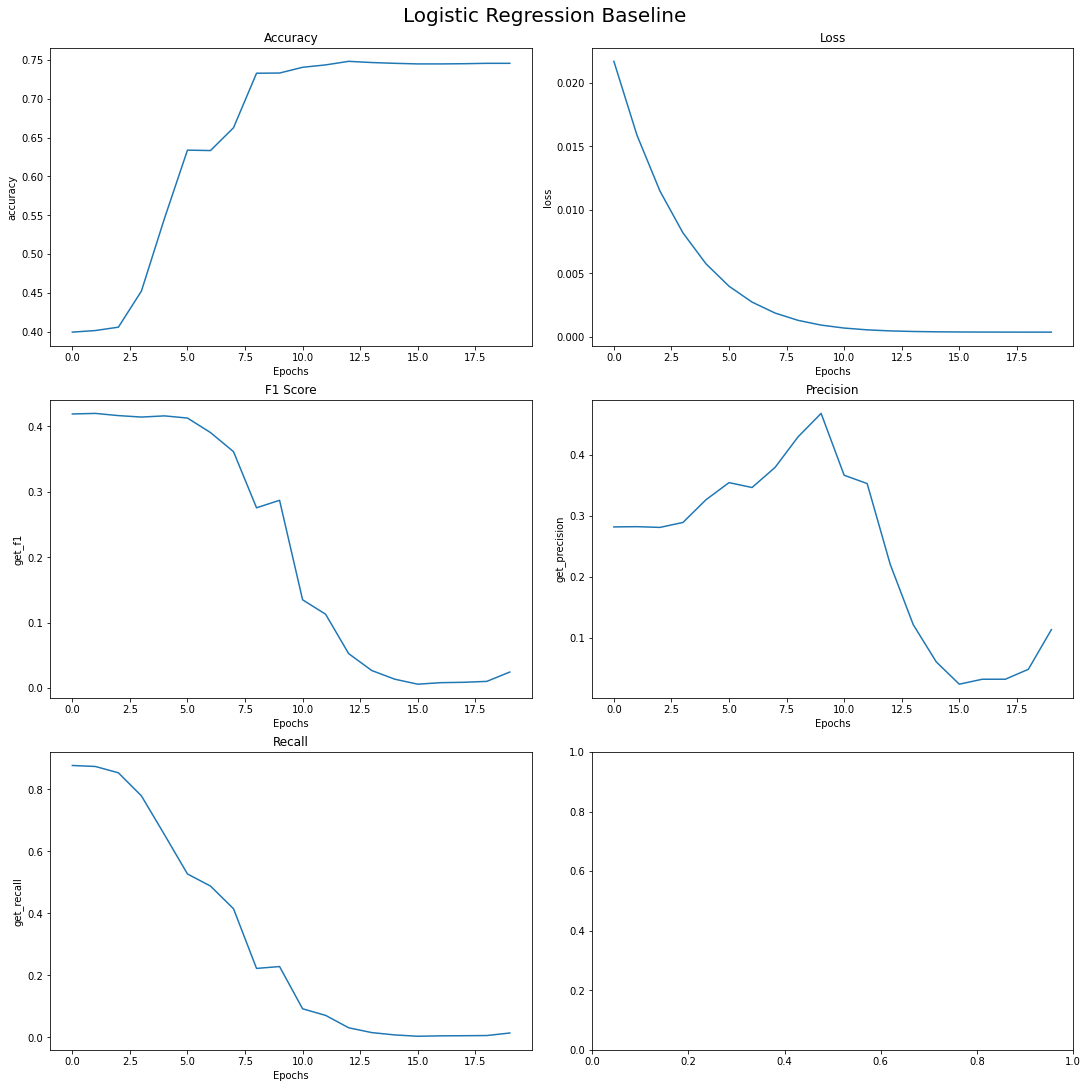

In [95]:
def plot_graphs(axs, gi1:int, gi2:int, history, string:str, title:str):
    """plots the graphs based on the provided parameters.

    Args:
        axs (plot): list of plots
        gi1 (int): row
        gi2 (int): col
        history (data_history): values of the label
        string (str): y label
        title (str): plot title
    """
    axs[gi1,gi2].plot(history[string])
    axs[gi1,gi2].set(xlabel="Epochs", ylabel=string,title=title)

fig, axs = plt.subplots(nrows=3,ncols=2, figsize=(15, 15), constrained_layout=True)
                        
plot_graphs(axs, 0,0, data_history.history, 'accuracy', 'Accuracy')
plot_graphs(axs, 0,1, data_history.history, 'loss', 'Loss')
plot_graphs(axs, 1,0, data_history.history, 'get_f1', 'F1 Score')
plot_graphs(axs, 1,1, data_history.history, 'get_precision', 'Precision')
plot_graphs(axs, 2,0, data_history.history, 'get_recall', 'Recall')

fig.suptitle("Logistic Regression Baseline", fontsize=20)

plt.savefig("test.jpg")